<a href="https://colab.research.google.com/github/newmantic/EMD/blob/main/EMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [2]:
def emd(signal, max_imfs=None, tol=1e-8):
    """
    Perform Empirical Mode Decomposition (EMD) on a signal.

    :param signal: 1D numpy array, the input signal to decompose.
    :param max_imfs: Maximum number of Intrinsic Mode Functions (IMFs) to extract.
    :param tol: Tolerance level to stop sifting when the change is below this threshold.
    :return: A list of IMFs and the residue.
    """
    def extract_max_min(signal):
        maxima = np.array([i for i in range(1, len(signal)-1) if signal[i] > signal[i-1] and signal[i] > signal[i+1]])
        minima = np.array([i for i in range(1, len(signal)-1) if signal[i] < signal[i-1] and signal[i] < signal[i+1]])
        return maxima, minima

    def is_monotonic(signal):
        return np.all(np.diff(signal) >= 0) or np.all(np.diff(signal) <= 0)

    def sifting_process(signal):
        h = signal
        for _ in range(100):  # Maximum number of sifting iterations
            maxima, minima = extract_max_min(h)
            if len(maxima) < 2 or len(minima) < 2:
                break
            # Interpolation
            upper_env = CubicSpline(maxima, h[maxima])(np.arange(len(signal)))
            lower_env = CubicSpline(minima, h[minima])(np.arange(len(signal)))
            mean_env = (upper_env + lower_env) / 2
            h_new = h - mean_env

            # Check for convergence
            if np.linalg.norm(h - h_new) < tol:
                break
            h = h_new
        return h, signal - h

    imfs = []
    residual = signal

    while not is_monotonic(residual) and (max_imfs is None or len(imfs) < max_imfs):
        imf, residual = sifting_process(residual)
        imfs.append(imf)

    return imfs, residual

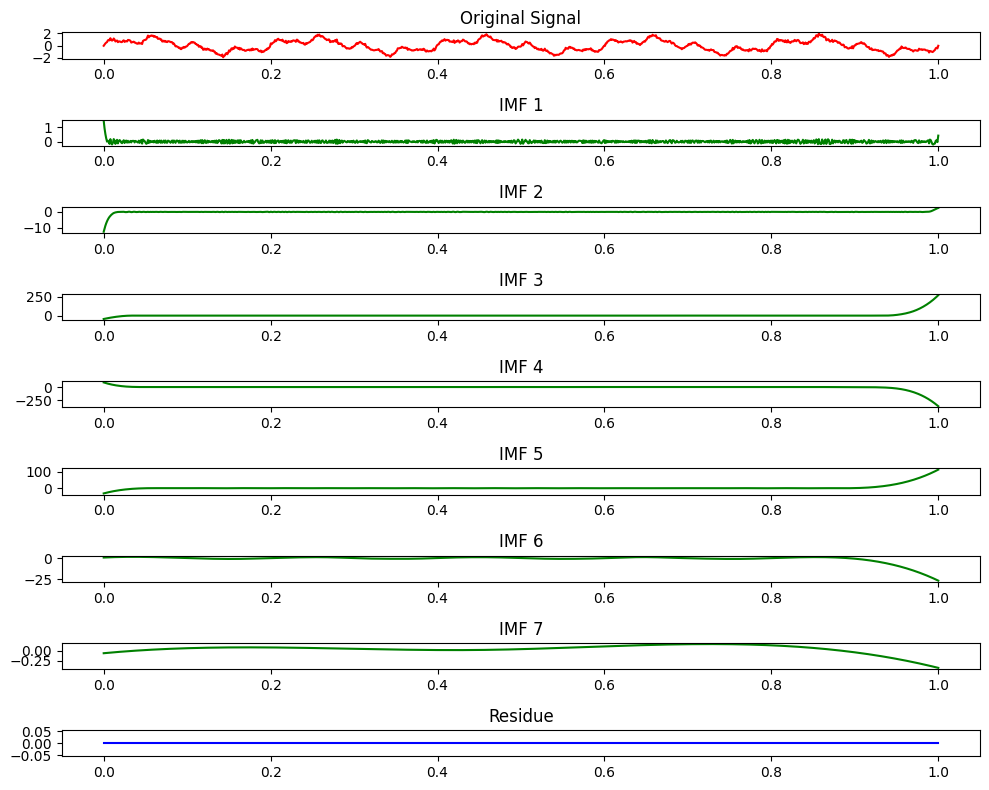

In [3]:
def test_case_emd():
    # Create a complex signal with multiple sine waves and noise
    t = np.linspace(0, 1, 1000)
    signal = (np.sin(2 * np.pi * 5 * t) +
              0.5 * np.sin(2 * np.pi * 20 * t) +
              0.3 * np.sin(2 * np.pi * 40 * t) +
              0.1 * np.random.randn(t.size))

    # Apply EMD
    imfs, residue = emd(signal)

    # Plot the results
    plt.figure(figsize=(10, 8))

    plt.subplot(len(imfs) + 2, 1, 1)
    plt.plot(t, signal, 'r')
    plt.title('Original Signal')

    for i, imf in enumerate(imfs):
        plt.subplot(len(imfs) + 2, 1, i + 2)
        plt.plot(t, imf, 'g')
        plt.title(f'IMF {i + 1}')

    plt.subplot(len(imfs) + 2, 1, len(imfs) + 2)
    plt.plot(t, residue, 'b')
    plt.title('Residue')

    plt.tight_layout()
    plt.show()

test_case_emd()